5.3.1.  Пример: предсказание финансовых показателей

(0.0, 0.25)

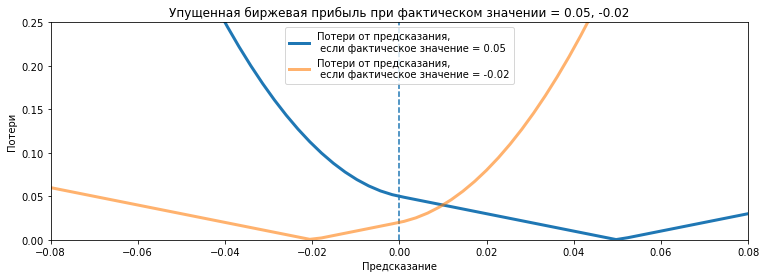

In [4]:
%matplotlib inline
import scipy.stats as stats
from IPython.core.pylabtools import figsize
import numpy as np
import matplotlib.pyplot as plt

figsize(12.5, 4)

# новая функция потерь для финансовой сферы 
def stock_loss(true_return, yhat, alpha=100.):
    if true_return*yhat < 0:
        # Знаки противоположны — это плохо 
        return alpha*yhat**2 - np.sign(true_return)*yhat \
                    + abs(true_return)
    else:
        return abs(true_return - yhat)
    
pred = np.linspace(-.08, .12, 75)

true_value = .05
plt.plot(pred, [stock_loss(true_value, _p) for _p in pred], 
         label = "Потери от предсказания,\n если фактическое значение = 0.05", lw=3)

true_value = -.02
plt.plot(pred, [stock_loss(true_value, _p) for _p in pred], alpha=0.6, \
         label="Потери от предсказания,\n если фактическое значение = -0.02", lw=3)


plt.vlines(0, 0, .25, linestyles="--")
plt.legend()
plt.title(u"Упущенная биржевая прибыль при фактическом значении = 0.05, -0.02" );
plt.xlabel("Предсказание")
plt.ylabel("Потери" )
plt.xlim(-0.08, .08)
plt.ylim(0, 0.25)


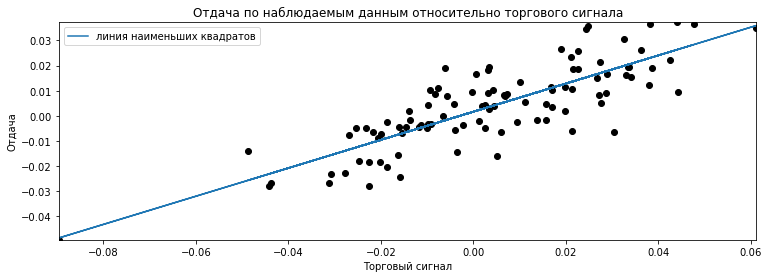

In [13]:
# Код для создания фиктивных данных
N = 100
X = 0.025 * np.random.randn(N)
Y = 0.5 * X + 0.01 * np.random.randn(N)
ls_coef_ = np.cov(X, Y)[0,1]/np.var(X)
ls_intercept = Y.mean() - ls_coef_*X.mean()
plt.scatter(X, Y, c="k")
plt.xlabel(u"Торговый сигнал")
plt.ylabel(u"Отдача")
plt.title(u"Отдача по наблюдаемым данным относительно торгового сигнала")
plt.plot(X, ls_coef_ * X + ls_intercept, label="линия наименьших квадратов")
plt.xlim(X.min(), X.max())
plt.ylim(Y.min(), Y.max())
plt.legend(loc="upper left");

In [18]:
import pymc as pm
from pymc.Matplot import plot as mcplot
std = pm.Uniform("std", 0, 100, trace=False)

@pm.deterministic
def prec(U=std):
    return 1.0 / U **2

beta = pm.Normal("beta", 0, 0.0001)
alpha = pm.Normal("alpha", 0, 0.0001)

@pm.deterministic
def mean(X=X, alpha=alpha, beta=beta):
    return alpha + beta * X

obs = pm.Normal("obs", mean, prec, value=Y, observed=True)
mcmc = pm.MCMC([obs, beta, alpha, std, prec])
mcmc.sample(100000, 80000);

 [-----------------100%-----------------] 100000 of 100000 complete in 21.0 sec

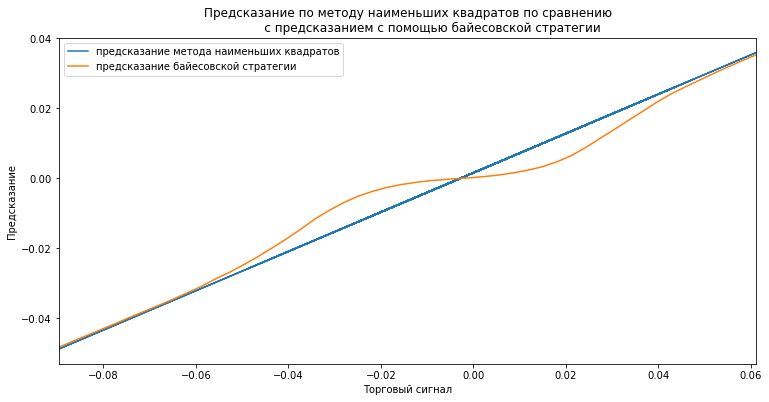

In [19]:
figsize(12.5, 6)
from scipy.optimize import fmin

def stock_loss(price, pred, coef=500):
    sol = np.zeros_like(price)
    ix = price*pred < 0
    sol[ix] = coef * pred **2 - np.sign(price[ix]) * pred + abs(price[ix])
    sol[~ix] = abs(price[~ix] - pred)
    return sol

tau_samples = mcmc.trace("prec")[:]
alpha_samples = mcmc.trace("alpha")[:]
beta_samples = mcmc.trace("beta")[:]

N = tau_samples.shape[0]
noise = 1. / np.sqrt(tau_samples) * np.random.randn(N)
possible_outcomes = lambda signal: alpha_samples + \
                                   beta_samples * signal + noise
opt_predictions = np.zeros(50)
trading_signals = np.linspace(X.min(), X.max(), 50)
for i, _signal in enumerate(trading_signals): # функция  enumerate(list)  при каждой  итерации  
    # возвращает  пару  объектов:  значение  индекса  i  и  
    # значение соответствующего элемента списка. 
    _possible_outcomes = possible_outcomes(_signal)
    tomin = lambda pred: stock_loss(_possible_outcomes, pred).mean()
    opt_predictions[i] = fmin(tomin, 0, disp=False)
    
    
plt.xlabel(u"Торговый сигнал")
plt.ylabel(u"Предсказание")
plt.title(u"Предсказание по методу наименьших квадратов по сравнению\n   \
          с предсказанием с помощью байесовской стратегии" )
plt.plot(X, ls_coef_ * X + ls_intercept, \
         label=u"предсказание метода наименьших квадратов")
plt.xlim(X.min(), X.max())
plt.plot(trading_signals, opt_predictions, \
         label=u"предсказание байесовской стратегии")
plt.legend(loc="upper left");

# 5.3.2. Пример: поиск расположения тёмной материи

![Alt-текст](https://grodno24.com/assets/thumbs/images/2019/09/galaktika.jpg "Искривлённая галактика")    

![Alt-текст](https://storage.googleapis.com/kaggle-competitions/kaggle/3084/media/heic0814f.jpg "Искривлённая галактика")    

![Alt-текст](https://storage.googleapis.com/kaggle-competitions/kaggle/3084/media/reorderdarkmatter.png "Искривлённая галактика")    

![Alt-текст](https://storage.googleapis.com/kaggle-competitions/kaggle/3084/media/a1689_opt.png "Темная материя в действии")

Таблица данных по галактикам на участке неба #3.
--------------------------------------------------------
  координата_x  координата_y     e_1         e_2
--------------------------------------------------------
[[ 1.62690e+02  1.60006e+03  1.14664e-01 -1.90326e-01]
 [ 2.27228e+03  5.40040e+02  6.23555e-01  2.14979e-01]
 [ 3.55364e+03  2.69771e+03  2.83527e-01 -3.01870e-01]]


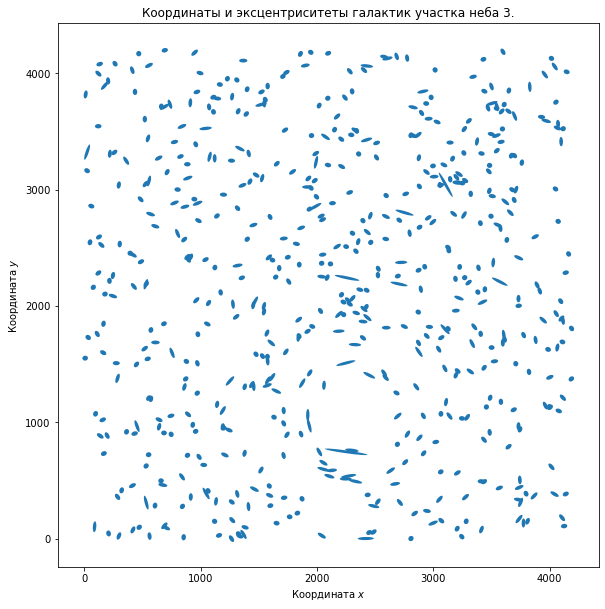

In [19]:
import matplotlib.pyplot as plt
import numpy as np

from Probab_Program.Chapter5_LossFunctions.draw_sky2 import draw_sky
#from draw_sky2 import draw_sky
n_sky = 3 # выбираем файл/участок неба для изучения Training_Sky3.csv
data = np.genfromtxt("Probab_Program//Chapter5_LossFunctions//data//Train_Skies//Train_Skies//\
Training_Sky%d.csv"%(n_sky),
                      dtype=None,
                      skip_header=1,
                      delimiter=",",
                      usecols=[1,2,3,4])
print ("Таблица данных по галактикам на участке неба #%d."%n_sky)
print('--'*28)
print ("  координата_x  координата_y     e_1         e_2")
print('--'*28)

print (data[:3])
fig = draw_sky(data)
plt.title(u"Координаты и эксцентриситеты галактик участка неба %d."%n_sky)
plt.xlabel(u"Координата $x$")
plt.ylabel(u"Координата $y$");

5.3.4.  Априорные распределения

In [ ]:
exp_mass_large = pm.Uniform("exp_mass_large", 40, 180)
@pm.deterministic
def mass_large(u = exp_mass_large):
    return np.log(u)

5.3.5.  Обучение и PyMC-реализация

In [20]:
def euclidean_distance(x, y):
    return np.sqrt(((x - y) **2).sum(axis=1))

def f_distance(gxy_pos, halo_pos, c):
    # ..._position должен быть двумерным массивом Numpy.
    return np.maximum(euclidean_distance(gxy_pos, halo_pos), c)[:,None]
def tangential_distance(glxy_position, halo_position):
    # ..._position должен быть двумерным массивом Numpy.
    delta = glxy_position - halo_position
    t = (2*np.arctan(delta[:,1]/delta[:,0]))[:,None]
    return np.concatenate([-np.cos(t), -np.sin(t)], axis=1)

import pymc as pm
# Задаем порядок массы гало.
mass_large = pm.Uniform("mass_large", 40, 180, trace=False)
# Задаем исходные априорные местоположения гало в виде двумерного
# равномерного распределения.
halo_position = pm.Uniform("halo_position", 0, 4200, size=(1,2))
@pm.deterministic
def mean(mass=mass_large, h_pos=halo_position, glx_pos=data[:,:2]):
    return mass/f_distance(glx_pos, h_pos, 240)*\
            tangential_distance(glx_pos, h_pos)
ellpty = pm.Normal("ellipticity", mean, 1./0.05, observed=True, value=data[:,2:] )
mcmc = pm.MCMC([ellpty, mean, halo_position, mass_large])
map_ = pm.MAP([ellpty, mean, halo_position, mass_large])
map_.fit()
mcmc.sample(200000, 140000, 3)

 [-----------------100%-----------------] 200000 of 200000 complete in 139.7 sec

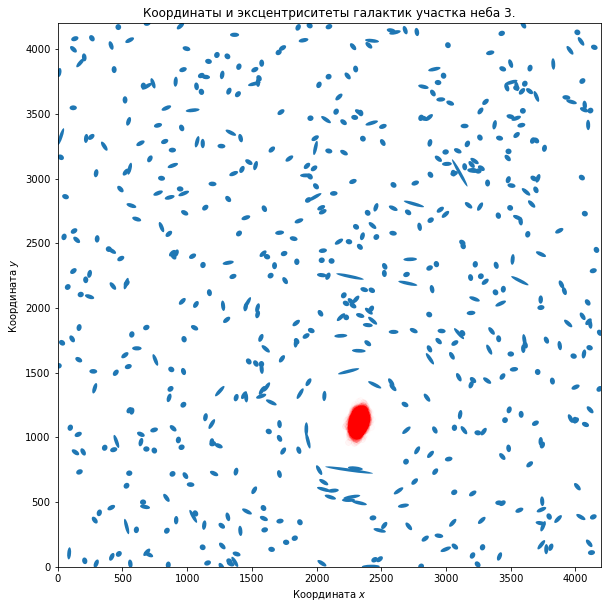

In [21]:
t = mcmc.trace("halo_position")[:].reshape( 20000,2)
fig = draw_sky(data)
plt.title(u"Координаты и эксцентриситеты галактик участка неба %d."%n_sky)
plt.xlabel(u"Координата $x$")
plt.ylabel(u"Координата $y$");
plt.scatter(t[:,0], t[:,1], alpha=0.015, c="r")
plt.xlim(0, 4200)
plt.ylim(0, 4200);

In [25]:
halo_data = np.genfromtxt("Probab_Program//Chapter5_LossFunctions//data//Training_halos.csv",
                     delimiter=",",
                     usecols=[1,2,3,4,5,6,7,8,9],
                     skip_header=1)
print (halo_data[n_sky])

[1.00000e+00 1.40861e+03 1.68586e+03 1.40861e+03 1.68586e+03 0.00000e+00
 0.00000e+00 0.00000e+00 0.00000e+00]


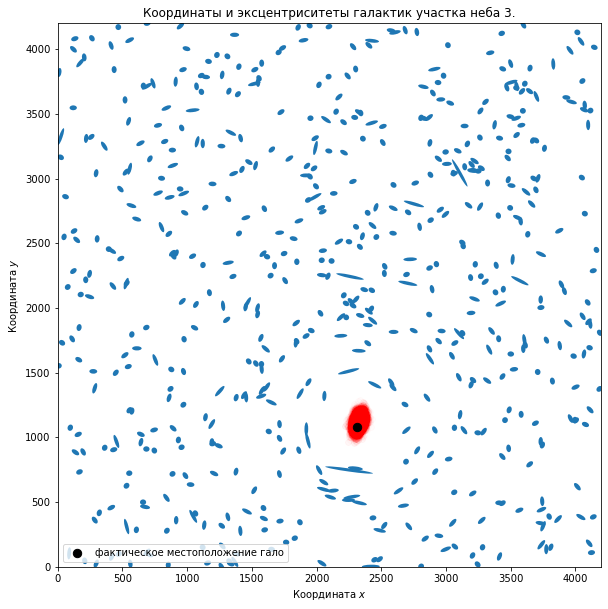

In [26]:
fig = draw_sky(data)
plt.title(u"Координаты и эксцентриситеты галактик участка неба %d."%n_sky)
plt.xlabel(u"Координата $x$")
plt.ylabel(u"Координата $y$");
plt.scatter(t[:,0], t[:,1], alpha=0.015, c="r")
plt.scatter(halo_data[n_sky-1][3], halo_data[n_sky-1][4],
            label=u"фактическое местоположение гало",
            c="k", s=70)
plt.legend(scatterpoints=1, loc="lower left")
plt.xlim(0, 4200)
plt.ylim(0, 4200);

In [28]:
print ("Фактическое местоположение гало:", halo_data[n_sky][3], halo_data[n_sky][4])

Фактическое местоположение гало: 1408.61 1685.86


In [29]:
mean_posterior = t.mean(axis=0).reshape(1,2)
print (mean_posterior)

[[2324.1701513  1123.86561723]]


In [32]:
from Probab_Program.Chapter5_LossFunctions.DarkWorldsMetric import main_score
_halo_data = halo_data[n_sky-1]
nhalo_all = _halo_data[0].reshape(1,1)
x_true_all = _halo_data[3].reshape(1,1)
y_true_all = _halo_data[4].reshape(1,1)
x_ref_all = _halo_data[1].reshape(1,1)
y_ref_all = _halo_data[2].reshape(1,1)
sky_prediction = mean_posterior
print ("При использовании среднего значения:")
main_score(nhalo_all, x_true_all, y_true_all, \
           x_ref_all, y_ref_all, sky_prediction)
# А в худшем случае?
print()
random_guess = np.random.randint(0, 4200, size=(1,2))
print ("При использовании случайного местоположения:", random_guess)
main_score(nhalo_all, x_true_all, y_true_all, \
           x_ref_all, y_ref_all, random_guess)
print()

При использовании среднего значения:
Your average distance in pixels you are away from the true halo is 42.74708886289722
Your average angular vector is 1.0
Your score for the training data is 1.0427470888628971

При использовании случайного местоположения: [[3859  221]]
Your average distance in pixels you are away from the true halo is 1767.1340840185273
Your average angular vector is 1.0
Your score for the training data is 2.7671340840185277



In [33]:
from pymc.Matplot import plot as mcplot


def halo_posteriors(n_halos_in_sky, galaxy_data,
                    samples=5e5, burn_in=34e4, thin=4):
    # set the size of the halo's mass
    """
    exp_mass_large = pm.Uniform("exp_mass_large", 40, 180)
    @pm.deterministic
    def mass_large(exp_mass_large = exp_mass_large):
        return np.log(exp_mass_large)
    """

    mass_large = pm.Uniform("mass_large", 40, 180)

    mass_small_1 = 20
    mass_small_2 = 20

    masses = np.array([mass_large, mass_small_1, mass_small_2], dtype=object)

    # set the initial prior positions of the halos, it's a 2-d Uniform dist.
    halo_positions = pm.Uniform("halo_positions", 0, 4200,
                                size=(n_halos_in_sky, 2))  # notice this size

    fdist_constants = np.array([240, 70, 70])

    @pm.deterministic
    def mean(mass=masses, h_pos=halo_positions, glx_pos=data[:, :2],
             n_halos_in_sky=n_halos_in_sky):

        _sum = 0
        for i in range(n_halos_in_sky):
            _sum += mass[i] / f_distance(glx_pos, h_pos[i, :], fdist_constants[i]) *\
                tangential_distance(glx_pos, h_pos[i, :])

        return _sum

    ellpty = pm.Normal("ellipcity", mean, 1. / 0.05, observed=True,
                       value=data[:, 2:])

    map_ = pm.MAP([ellpty, mean, halo_positions, mass_large])
    map_.fit(method="fmin_powell")

    mcmc = pm.MCMC([ellpty, mean, halo_positions, mass_large])
    mcmc.sample(samples, burn_in, thin)
    return mcmc.trace("halo_positions")[:]
    

In [34]:


n_sky = 215
data = np.genfromtxt("Probab_Program//Chapter5_LossFunctions//data//Train_Skies//Train_Skies//\
Training_Sky%d.csv" % (n_sky),
                      dtype=None,
                      skip_header=1,
                      delimiter=",",
                      usecols=[1, 2, 3, 4])

In [35]:
# there are 3 halos in this file.
samples = 10.5e5
traces = halo_posteriors(3, data, samples=samples,
                         burn_in=9.5e5,
                         thin=10)

 [-----------------100%-----------------] 1050000 of 1050000 complete in 1259.5 sec

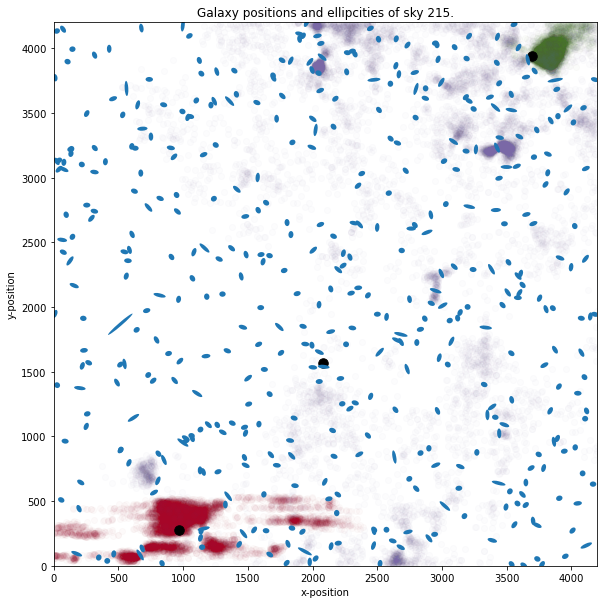

In [36]:

fig = draw_sky(data)
plt.title("Galaxy positions and ellipcities of sky %d." % n_sky)
plt.xlabel("x-position")
plt.ylabel("y-position")

colors = ["#467821", "#A60628", "#7A68A6"]

for i in range(traces.shape[1]):
    plt.scatter(traces[:, i, 0], traces[:, i, 1], c=colors[i], alpha=0.02)


for i in range(traces.shape[1]):
    plt.scatter(halo_data[n_sky - 1][3 + 2 * i], halo_data[n_sky - 1][4 + 2 * i],
                label="True halo position",
                c="k", s=90)

# plt.legend(scatterpoints = 1)
plt.xlim(0, 4200)
plt.ylim(0, 4200);

In [37]:
_halo_data = halo_data[n_sky - 1]
print(traces.shape)

mean_posterior = traces.mean(axis=0).reshape(1, 6)
print(mean_posterior)


nhalo_all = _halo_data[0].reshape(1, 1)
x_true_all = _halo_data[3].reshape(1, 1)
y_true_all = _halo_data[4].reshape(1, 1)
x_ref_all = _halo_data[1].reshape(1, 1)
y_ref_all = _halo_data[2].reshape(1, 1)
sky_prediction = mean_posterior


print("При использовании среднего значения:")
main_score([1], x_true_all, y_true_all,
           x_ref_all, y_ref_all, sky_prediction)

# what's a bad score?
print("\n")
random_guess = np.random.randint(0, 4200, size=(1, 2))
print("Using a random location:", random_guess)
main_score([1], x_true_all, y_true_all,
           x_ref_all, y_ref_all, random_guess)

(10000, 3, 2)
[[3824.35309659 3965.30302602 1017.57797373  311.23135206 2782.26762438
  2838.62291507]]
При использовании среднего значения:
Your average distance in pixels you are away from the true halo is 130.01305327027686
Your average angular vector is 1.0
Your score for the training data is 1.1300130532702768


Using a random location: [[3653 1761]]
Your average distance in pixels you are away from the true halo is 2181.4625585831172
Your average angular vector is 1.0
Your score for the training data is 3.1814625585831173


3.1814625585831173

5.4.  Выводы